<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_Pytorch/blob/main/Model/GPT_2/GPT2_GEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentencepiece : https://github.com/google/sentencepiece/blob/master/python/README.md

### 신문 말뭉치 2022

In [ ]:
cd drive/MyDrive/Pytorch\ NLP/GPT-2/data_in

In [ ]:
cd data_in

/content/drive/MyDrive/Pytorch NLP/GPT-2/data_in


In [ ]:
import json

In [ ]:
with open('train.json') as f:
  train=json.load(f)

In [ ]:
import pprint

In [ ]:
pprint.pprint(train['document'][:2])

[{'id': 'NPRW2200000004.1',
  'metadata': {'author': '뉴욕=백종민',
               'date': '20210101',
               'original_topic': '정치,북한|정치,외교|국제,미국_북미',
               'publisher': '아시아경제',
               'title': '아시아경제 2021년 기사',
               'topic': '사회'},
  'paragraph': [{'form': '“북, 유럽의회에 미국과 좋은 관계 희망”', 'id': 'NPRW2200000004.1.1'},
                {'form': '북한이 최근 유럽의회와 접촉해 ‘미국과 좋은 관계를 원한다’는 뜻을 밝혔다는 보도가 나왔다. '
                         '조 바이든 미국 행정부 출범을 앞둔 상황에서 북한이 도발보다는 대화에 방점을 둔 것인지 '
                         '주목된다.',
                 'id': 'NPRW2200000004.1.2'},
                {'form': '월스트리트저널(WSJ)은 31일(현지시간) 소식통을 인용, 북한이 지난 11월 미 대선이 '
                         '열리기 며칠 전 유럽의회 한반도관계대표단과 접촉해 온라인 면담을 요청해 성사됐다고 전했다.',
                 'id': 'NPRW2200000004.1.3'},
                {'form': '이번 면담은 주베를린 북한대사관이 제안했고 오스트리아 출신의 루카스 만들 유럽의회 '
                         '한반도관계대표단 회장이 참석해 12월 초에 열렸다.',
                 'id': 'NPRW2200000004.1.4'},
                {'form': '한 시간가량의 화상회

In [ ]:
len(train['document'])

81389

In [ ]:
from tqdm import tqdm

In [ ]:
train_data=[]

for sample in tqdm(train['document']):
  train_data+=[para['form'] for para in sample['paragraph']]

100%|██████████| 81389/81389 [00:00<00:00, 318213.49it/s]


In [ ]:
train_data[:4]

['“북, 유럽의회에 미국과 좋은 관계 희망”',
 '북한이 최근 유럽의회와 접촉해 ‘미국과 좋은 관계를 원한다’는 뜻을 밝혔다는 보도가 나왔다. 조 바이든 미국 행정부 출범을 앞둔 상황에서 북한이 도발보다는 대화에 방점을 둔 것인지 주목된다.',
 '월스트리트저널(WSJ)은 31일(현지시간) 소식통을 인용, 북한이 지난 11월 미 대선이 열리기 며칠 전 유럽의회 한반도관계대표단과 접촉해 온라인 면담을 요청해 성사됐다고 전했다.',
 '이번 면담은 주베를린 북한대사관이 제안했고 오스트리아 출신의 루카스 만들 유럽의회 한반도관계대표단 회장이 참석해 12월 초에 열렸다.']

In [ ]:
with open('paper_corpus.txt','w') as c:
  for sent in train_data:
    c.write(sent+'\n')

### NSMC

In [ ]:
import urllib

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt','train.txt')

('train.txt', <http.client.HTTPMessage at 0x79a87b7f9b40>)

In [ ]:
cd ~

/root


In [ ]:
temp=[]

In [ ]:
with open('train.txt','r') as f:
  f.readline()
  for sent in f.readlines():
    data = sent.split('\t')
    temp.append(data[1])

In [ ]:
len(temp)

150000

In [ ]:
cd drive/MyDrive/Pytorch\ NLP/GPT-2/data_in/gpt2_ckpt

/content/drive/MyDrive/Pytorch NLP/GPT-2/data_in/gpt2_ckpt


In [ ]:
with open('corpus.txt','w') as f:
  for sent in temp:
    f.write(f'\n {sent}')

### Sentencepiece

https://keep-steady.tistory.com/7

In [ ]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
import sentencepiece as spm

In [ ]:
# Tokenizer from NSMC
spm.SentencePieceTrainer.train(input='corpus.txt',model_prefix='kor_tokenizer',vocab_size=50257, model_type='bpe',max_sentence_length=9999999,pad_id=0,unk_id=1,bos_id=2,eos_id=3)

In [ ]:
ls

gpt2_ckpt/  gpt_ckpt.zip         kor_tokenizer.vocab  train.json
gpt_ckpt/   kor_tokenizer.model  paper_corpus.txt


In [ ]:
# Tokenizer from 신문 말뭉치 2022
spm.SentencePieceTrainer.train(input='paper_corpus.txt',model_prefix='kor_tokenizer',vocab_size=50257, model_type='bpe',max_sentence_length=9999999,pad_id=0,unk_id=1,bos_id=2,eos_id=3)

### Tokenizer

In [ ]:
sp=spm.SentencePieceProcessor()
sp.Load('kor_tokenizer.model')

True

In [ ]:
sp.EncodeAsPieces('안녕하세요 저는 사람이에요.')

['▁안녕', '하세요', '▁저는', '▁사람이', '에', '요', '.']

In [ ]:
sp.encode('안녕하세요 저는 사람이에요.')

[41506, 17697, 10530, 3116, 48943, 49089, 48941]

In [ ]:
sp.encode('그래')

[312]

In [ ]:
sp.bos_id()

2

In [ ]:
vocab = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]

In [ ]:
print('0 :{}, 1 :{} , 2 :{}, 3 :{} '.format(vocab[0],vocab[1],vocab[2],vocab[3]))

0 :<pad>, 1 :<unk> , 2 :<s>, 3 :</s> 


## Input for fine-tuning

### filtering (신문 데이터는 필터링 하지 않음)

In [ ]:
import re

In [ ]:
temp[5]

'막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.'

In [ ]:
filtered_sent = [ ' '.join((re.sub('[^가-힣0-9 ]',' ',sent)).split()) for sent in temp]

In [ ]:
filtered_sent[11]

'볼때마다 눈물나서 죽겠다90년대의 향수자극 허진호는 감성절제멜로의 달인이다'

### padding and truncation

NSMC

In [ ]:
import numpy as np

In [ ]:
tokenized_len=[len(sp.encode(sent)) for sent in filtered_sent ]

In [ ]:
print('3사분위 길이 :{}'.format(np.percentile(tokenized_len,99)))

3사분위 길이 :47.0


In [ ]:
MAX_LEN=47

신문 말뭉치 2022

In [ ]:
tokenized_len=[len(sp.encode(sent)) for sent in train_data ]

In [ ]:
print('3사분위 길이 :{}'.format(np.percentile(tokenized_len,75)))
print('상위 99퍼 길이 :{}'.format(np.percentile(tokenized_len,99)))

3사분위 길이 :52.0
상위 99퍼 길이 :109.0


In [ ]:
# 어짜피 pad는 loss계산에서 제외할 것이기에 최대한 문장 길이를 길게 포함시키자
MAX_LEN =100

In [ ]:
import torch

In [ ]:
def preprocess_input_output(input,max_len):
  # input : (samples, sent_len)

  train_input=[]
  train_output=[]

  # append <s>, </s>, <pad>
  for sent in input:
    if len(sp.encode(sent))<max_len:
      pad_len = max_len-len(sp.encode(sent))-1
      train_input.append([sp.bos_id()]+sp.encode(sent)+[sp.pad_id()]*pad_len)
      train_output.append(sp.encode(sent)+[sp.eos_id()]+[sp.pad_id()]*pad_len)
    else: # truncation
      train_input.append([sp.bos_id()]+sp.encode(sent)[:max_len-1])
      train_output.append(sp.encode(sent)[:max_len-1]+[sp.eos_id()])

  return torch.LongTensor(train_input), torch.LongTensor(train_output) # (samples, max_len)

In [ ]:
train_input, train_output = preprocess_input_output(train_data,MAX_LEN)

In [ ]:
count =0
for sent in train_input:
  if sp.unk_id() in sent:
    count+=1
count

28520

In [ ]:
train_input[0]

tensor([    2,    11, 49244, 48957,  1220, 27067,  3857,  1552,   257,  1271,
        48988,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
train_output[0]

tensor([   11, 49244, 48957,  1220, 27067,  3857,  1552,   257,  1271, 48988,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
from torch.utils.data import Dataset,DataLoader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,x,y):
    self.x=x
    self.y=y

  def __getitem__(self,index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.x.size()[0]

In [ ]:
train_dataset = CustomDataset(train_input,train_output)

In [ ]:
train_iter = DataLoader(train_dataset,batch_size=32)

In [ ]:
next(iter(train_iter))

[tensor([[    2,    11, 49244,  ...,     0,     0,     0],
         [    2,  6393,   337,  ...,     0,     0,     0],
         [    2,  7002, 49004,  ...,     0,     0,     0],
         ...,
         [    2, 48838,  1199,  ...,     0,     0,     0],
         [    2,   900,  4412,  ...,     0,     0,     0],
         [    2, 24151,    59,  ...,     0,     0,     0]]),
 tensor([[   11, 49244, 48957,  ...,     0,     0,     0],
         [ 6393,   337,  1220,  ...,     0,     0,     0],
         [ 7002, 49004,  7690,  ...,     0,     0,     0],
         ...,
         [48838,  1199,    54,  ...,     0,     0,     0],
         [  900,  4412,   731,  ...,     0,     0,     0],
         [24151,    59,   123,  ...,     0,     0,     0]])]

### config & model_weight

In [ ]:
urllib.request.urlretrieve('https://huggingface.co/gpt2/resolve/main/config.json','config.json')

('config.json', <http.client.HTTPMessage at 0x7fdd07c1ada0>)

In [ ]:
urllib.request.urlretrieve('https://huggingface.co/gpt2/resolve/main/model.safetensors','model.safetensors')

('model.safetensors', <http.client.HTTPMessage at 0x7fdd07c19ed0>)

In [ ]:
cd ~

/root


In [ ]:
cd ..

/


In [ ]:
cd content

/content


In [ ]:
cd drive/MyDrive/Pytorch\ NLP/GPT-2/data_in

/content/drive/MyDrive/Pytorch NLP/GPT-2/data_in


In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4ab74ff4e824669769cb28e4fd058e4a74225cd1b74e2f8689bd7d1bba7de6a8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Top k & Top p

### torch.multinomial

In [ ]:
import torch
import torch.nn as nn

In [ ]:
a=torch.Tensor([1,2,3,4,5,6,7,8])
c=a>5
c

tensor([False, False, False, False, False,  True,  True,  True])

In [ ]:
mask=torch.cat([torch.BoolTensor([False]),c[:-1]])

In [ ]:
mask

tensor([False, False, False, False, False, False,  True,  True])

In [ ]:
d=a[mask]

In [ ]:
d

tensor([7., 8.])

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
  # logits = (vocab_size, )

  if top_k>0:
    top_k=min(top_k,logits.size()[0])
    indices_to_remove=logits<torch.topk(logits,top_k).values[-1] # smaller than the smallest value among the top_k values
    logits[indices_to_remove]=filter_value

  if top_p>0.0:
    sorted_logits,sorted_logits_index=torch.sort(logits,descending=True)
    prob_cumsum = torch.cumsum(nn.Softmax()(sorted_logits),dim=0)

    sorted_indices_to_remove=prob_cumsum>top_p
    sorted_indices_to_remove=torch.cat([torch.BoolTensor([False]),sorted_indices_to_remove[:-1]]) # prevent if first is True
    indices_to_remove = sorted_logits_index[sorted_indices_to_remove]

    logits[indices_to_remove]=filter_value

  return logits   # logits = (vocab_size, )


## Greedy & Generate_sentence Function

In [ ]:
def generate_sent(seed_word,model,max_len=100,greedy=False,top_k=0,top_p=0.0):
  sent= seed_word
  toked = sp.encode(sent)

  for _ in range(max_len):
    input_ids = torch.LongTensor([sp.bos_id()]+toked)[None,:] # input_ids = (1, cumulated_seq_len)
    outputs = model(input_ids)[0,-1,:] # outputs : (vocab_size, )

    if greedy:
      gen = sp.id_to_piece(outputs.argmax().tolist()) # outputs.argmax().tolist() -> int
    else:
      output_logits = top_k_top_p_filtering(outputs,top_k,top_p) # logits = (vocab_size, )
      gen = torch.multinomial(nn.Softmax(-1)(output_logits),num_samples=1,replacement=True).tolist()[0]
      gen = sp.id_to_piece(gen)
    if gen == '</s>':
      break

    sent+=gen.replace('▁',' ')
    toked=sp.encode(sent)

  return sent

## Huggingface Transformers

In [ ]:
ls

gpt2_ckpt/  gpt_ckpt.zip         kor_tokenizer.vocab  train.json
gpt_ckpt/   kor_tokenizer.model  paper_corpus.txt


In [ ]:
cd ..

/content/drive/MyDrive/Pytorch NLP/GPT-2


In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2LMHeadModel

## Model Pre-training

In [122]:
class GPT2Gen(nn.Module):
  def __init__(self,dir_path):
    super(GPT2Gen,self).__init__()
    self.gpt2 = GPT2LMHeadModel.from_pretrained(dir_path,ignore_mismatched_sizes=True)

  def forward(self,x):
    outputs=self.gpt2(x)[0]
    return torch.transpose(outputs,2,1) # (batch_size=1, vocab_size, max_len)

In [121]:
# hyperparameter
MAX_LEN=100
BATCH_SIZE=32
EPOCHS=10

device='cuda' if torch.cuda.is_available() else 'cpu'

In [123]:
ls

data_in/  data_out/  GPT2_GEN.ipynb  losses.npy


In [124]:
model = GPT2Gen('./data_in/gpt2_ckpt').to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)

In [125]:
emb=['gpt2.transformer.wte.weight','gpt2.transformer.wpe.weight']

In [126]:
for name,param in model.named_parameters():
  if name not in emb:
    param.requires_grad=False

In [ ]:
for name,param in model.named_parameters():
  print(f'{name}, {param.requires_grad}')

gpt2.transformer.wte.weight, True
gpt2.transformer.wpe.weight, True
gpt2.transformer.h.0.ln_1.weight, False
gpt2.transformer.h.0.ln_1.bias, False
gpt2.transformer.h.0.attn.c_attn.weight, False
gpt2.transformer.h.0.attn.c_attn.bias, False
gpt2.transformer.h.0.attn.c_proj.weight, False
gpt2.transformer.h.0.attn.c_proj.bias, False
gpt2.transformer.h.0.ln_2.weight, False
gpt2.transformer.h.0.ln_2.bias, False
gpt2.transformer.h.0.mlp.c_fc.weight, False
gpt2.transformer.h.0.mlp.c_fc.bias, False
gpt2.transformer.h.0.mlp.c_proj.weight, False
gpt2.transformer.h.0.mlp.c_proj.bias, False
gpt2.transformer.h.1.ln_1.weight, False
gpt2.transformer.h.1.ln_1.bias, False
gpt2.transformer.h.1.attn.c_attn.weight, False
gpt2.transformer.h.1.attn.c_attn.bias, False
gpt2.transformer.h.1.attn.c_proj.weight, False
gpt2.transformer.h.1.attn.c_proj.bias, False
gpt2.transformer.h.1.ln_2.weight, False
gpt2.transformer.h.1.ln_2.bias, False
gpt2.transformer.h.1.mlp.c_fc.weight, False
gpt2.transformer.h.1.mlp.c_fc.bi

In [ ]:
from tqdm import tqdm

In [ ]:
a=torch.Tensor([[1,1,1,0,0],[1,1,0,0,0]])
mask=~(a==0)

b=torch.Tensor([[3,2,5,0,0],[1,5,3,1,0]])
print(b*mask)
print((b*mask))

tensor([[3., 2., 5., 0., 0.],
        [1., 5., 0., 0., 0.]])
tensor(1.6000)


In [ ]:
def compute_loss(outputs,y,criterion):
  loss = criterion(outputs,y) # (batch_size, max_len)
  mask = ~(y==0)

  return (loss*mask).mean()

In [127]:
# additional training
model.load_state_dict(torch.load('./data_out/best_model/best_weight.pt'))

<All keys matched successfully>

In [ ]:
def train(model,optimizer,criterion,train_iter):
  model.train()
  losses=[]
  count=0
  total_loss = 0
  for batch in tqdm(train_iter):
    if count==4000:
      break
    count+=1
    x=batch[0].to(device)
    y=batch[1].to(device)

    outputs = model(x) # outputs : (batch_size, vocab_size, max_len)
    loss = compute_loss(outputs,y,criterion) # (batch_size, max_len )
    total_loss+=loss
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return total_loss/len(train_iter), losses

In [ ]:
import os

In [ ]:
cd ..

/content/drive/MyDrive/Pytorch NLP/GPT-2


In [ ]:
best_loss = None

for e in range(EPOCHS):
  avg_loss, losses=train(model,optimizer,criterion,train_iter)
  print('avg_loss : {}'.format(avg_loss))

  if not best_loss or avg_loss<best_loss:
    os.makedirs('./data_out/best_model',exist_ok=True)
    torch.save(model.state_dict(),'./data_out/best_model/best_weight.pt')
    best_loss=avg_loss

  4%|▍         | 840/22064 [10:18<4:22:42,  1.35it/s]

In [ ]:
import numpy as np

In [ ]:
losses=[loss.tolist() for loss in losses]

In [ ]:
ls

data_in/  data_out/  GPT2_GEN.ipynb  losses.npy


In [ ]:
np.save('./losses',np.array(losses))

In [ ]:
losses=np.load('losses.npy')

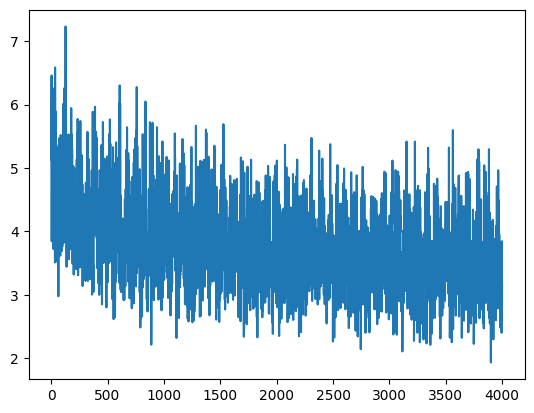

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
model.state_dict().keys()

odict_keys(['gpt2.transformer.wte.weight', 'gpt2.transformer.wpe.weight', 'gpt2.transformer.h.0.ln_1.weight', 'gpt2.transformer.h.0.ln_1.bias', 'gpt2.transformer.h.0.attn.c_attn.weight', 'gpt2.transformer.h.0.attn.c_attn.bias', 'gpt2.transformer.h.0.attn.c_proj.weight', 'gpt2.transformer.h.0.attn.c_proj.bias', 'gpt2.transformer.h.0.ln_2.weight', 'gpt2.transformer.h.0.ln_2.bias', 'gpt2.transformer.h.0.mlp.c_fc.weight', 'gpt2.transformer.h.0.mlp.c_fc.bias', 'gpt2.transformer.h.0.mlp.c_proj.weight', 'gpt2.transformer.h.0.mlp.c_proj.bias', 'gpt2.transformer.h.1.ln_1.weight', 'gpt2.transformer.h.1.ln_1.bias', 'gpt2.transformer.h.1.attn.c_attn.weight', 'gpt2.transformer.h.1.attn.c_attn.bias', 'gpt2.transformer.h.1.attn.c_proj.weight', 'gpt2.transformer.h.1.attn.c_proj.bias', 'gpt2.transformer.h.1.ln_2.weight', 'gpt2.transformer.h.1.ln_2.bias', 'gpt2.transformer.h.1.mlp.c_fc.weight', 'gpt2.transformer.h.1.mlp.c_fc.bias', 'gpt2.transformer.h.1.mlp.c_proj.weight', 'gpt2.transformer.h.1.mlp.c_pr

In [ ]:
model.train()

GPT2Gen(
  (gpt2): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
)

## Text Generative Model

In [ ]:
cd ..

/content/drive/MyDrive/Pytorch NLP/GPT-2


In [ ]:
ls

data_in/  data_out/  GPT2_GEN.ipynb  losses.npy


In [ ]:
class GPT2Gen(nn.Module):
  def __init__(self,dir_path):
    super(GPT2Gen,self).__init__()
    self.gpt2 = GPT2LMHeadModel.from_pretrained(dir_path,ignore_mismatched_sizes=True)

  def forward(self,x):
    return self.gpt2(x)[0] # (batch_size=1, cumulated_seq_len, vocab_size =50257)

In [ ]:
gpt2_model = GPT2Gen('./data_in/gpt2_ckpt')

Generate_sentences

In [ ]:
gpt2_model.load_state_dict(torch.load('data_out/best_model/best_weight.pt'))

<All keys matched successfully>

In [ ]:
gpt2_model.to('cpu')

GPT2Gen(
  (gpt2): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
)

In [119]:
generate_sent('오늘',gpt2_model,top_p=0.8)

<ipython-input-28-15fe6af09a52>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_cumsum = torch.cumsum(nn.Softmax()(sorted_logits),dim=0)


'오늘과장은 “아직 독 홍콩 어려운 만큼 이달 사업설계 독립 200원외국 선거를하지 않고 않았다”고 말했다.'